# Diffraction Monitor in Tidy3D

Here I explored the use of Diffraction Monitor ([Documentation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DiffractionMonitor.html)) on Huygen's Metasurface.

In [2]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import scienceplots

# Set logging level to ERROR to reduce output verbosity
td.config.logging_level = "ERROR"

In [3]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.1, wvl_max=1.6)
N = 301 # num_points
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0

In [4]:
# 1 Computational Domain Size
h = 0.220  # Height of cylinder
spc = 2
Lz = spc + h + h + spc

Px = Py = P = 0.666 # periodicity
sim_size = [Px, Py, Lz]

In [202]:
# 2 Grid Resolution
dl = P / 128
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

In [203]:
r = 0.242  # radius of the cylinder
n_Si = 3.5
Si = td.Medium(permittivity=n_Si**2, name='Si')
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)

# Background medium for the first simulation
n_glass = 1.4
n_SiO2 = 1.45
glass = td.Medium(permittivity=n_glass**2, name='glass')
SiO2 = td.Medium(permittivity=n_SiO2**2, name='oxide')

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=SiO2,
    name='substrate'
)

glass = td.Structure(
    geometry=td.Box(
        center=(0,0,Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=glass,
    name='superstrate'
)

# Background medium for the second simulation
# Polymer
n_polymer = 1.66
polymer = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(td.inf,td.inf,td.inf)
    ),
    medium=td.Medium(permittivity=n_polymer**2, name='polymer'),
    name='polymer'
)

source = td.PlaneWave(
    source_time=fr.to_gaussian_pulse(),
    size=(td.inf, td.inf, 0),
    center=(0, 0, Lz/2 - spc + 0.5 * lda0),
    direction="-",
    pol_angle=0
)

monitor = td.DiffractionMonitor(
    center=(0, 0, -Lz/2 + spc - 0.5 * lda0),
    size=(td.inf,td.inf,0),
    freqs=fr.freqs(N),
    name='diffraction_monitor',
    normal_dir='-', # away from structure
)

bandwidth = fr.fmax - fr.fmin
run_time = 200 / bandwidth

bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

In [204]:
def simulation_helper(background, monitors, run_time):
    """
    Create normalization and actual tidy3d simulations, visualize geometry, 
    and return both as a dictionary.

    Parameters
    ----------
    background : list of td.Structure
        Background structures (without the cylinder).
    monitors : list of td.Monitor
        Monitors for the normalization run.
    run_time : float
        Run time for the normalization simulation.

    Returns
    -------
    dict
        {"norm": Simulation without cylinder,
         "actual": Simulation with cylinder}

    Notes
    -----
    Saves cross-sectional plots of the actual simulation (x=0, y=0, z=0) 
    with grid overlay for verification.
    """
    sim_empty=td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=background,
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=bc
    )

    background.append(cylinder)
    sim_actual = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=background,
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=bc
    )

    # Always visualize simulation before running
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
    ax1.tick_params(axis='x', labelsize=7)
    ax2.tick_params(axis='x', labelsize=7)
    sim_actual.plot(x=0, ax=ax1)
    sim_actual.plot_grid(x=0, ax=ax1)
    sim_actual.plot(y=0, ax=ax2)
    sim_actual.plot_grid(y=0, ax=ax2)
    sim_actual.plot(z=0, ax=ax3)
    sim_actual.plot_grid(z=0, ax=ax3)
    plt.savefig(f'huygens_structure_{background[0].name}.png', dpi=300)
    plt.show()

    sims = {
        "norm": sim_empty,
        "actual": sim_actual,
    }

    return sims



### Simulation

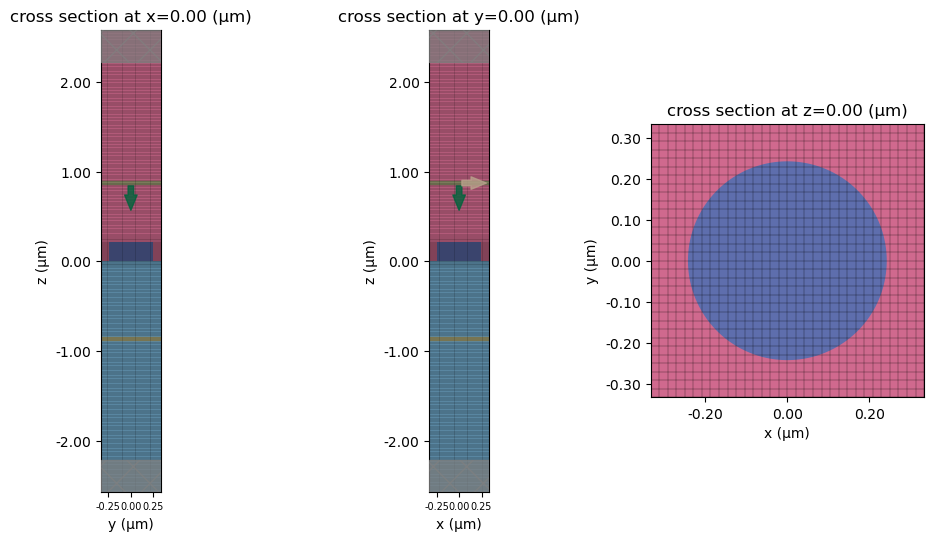

In [24]:
sims = simulation_helper(
    background=[substrate, glass],
    monitors=[monitor],
    run_time=run_time
)

In [25]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/huygens_diffraction")

Output()

20:41:03 EDT Started working on Batch containing 2 tasks.

20:41:05 EDT Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

20:41:16 EDT Batch complete.

Output()

## Diffraction Monitor Results

In [ ]:
dD = batch_data["actual"]["diffraction_monitor"]
norm_data = batch_data["norm"]["diffraction_monitor"]

# diffraction_data.help()

In [41]:
dD.monitor

DiffractionMonitor(attrs={}, type='DiffractionMonitor', center=(0.0, 0.0, -0.8718518518518521), size=(inf, inf, 0.0), name='diffraction_monitor', interval_space=(1, 1, 1), colocate=False, freqs=(187370286250000.0, 187654180623106.06, 187938074996212.12, 188221969369318.2, 188505863742424.25, 188789758115530.3, 189073652488636.38, 189357546861742.44, 189641441234848.47, 189925335607954.53, 190209229981060.6, 190493124354166.66, 190777018727272.72, 191060913100378.78, 191344807473484.84, 191628701846590.9, 191912596219696.97, 192196490592803.03, 192480384965909.1, 192764279339015.16, 193048173712121.22, 193332068085227.28, 193615962458333.34, 193899856831439.38, 194183751204545.44, 194467645577651.5, 194751539950757.56, 195035434323863.62, 195319328696969.7, 195603223070075.75, 195887117443181.8, 196171011816287.88, 196454906189393.94, 196738800562500.0, 197022694935606.06, 197306589308712.12, 197590483681818.2, 197874378054924.25, 198158272428030.3, 198442166801136.34, 198726061174242.4

In [42]:
dD.Er

<xarray.DiffractionDataArray (orders_x: 1, orders_y: 1, f: 301)> Size: 5kB
array([[[-0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
         -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
         -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
         -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,  0.-0.j,  0.-0.j,
          0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,
          0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,
...
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
         -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j, -0.+0.j,
         -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
         -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
         -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
         -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]]])
Coordinates:
  * orders_x  (orders_x) int64 8B 0
  * orders_y  (orders_y) int64 8B 0
  * f         (f) float64 2kB 1.874e+14 1.877e+14 ... 2.723e+14 2.725e+14
Attributes:
    long_name:  diffraction amplitude

In [ ]:
print(dD.medium) 

oxide

In [46]:
power = np.array(dD.power[0][0])

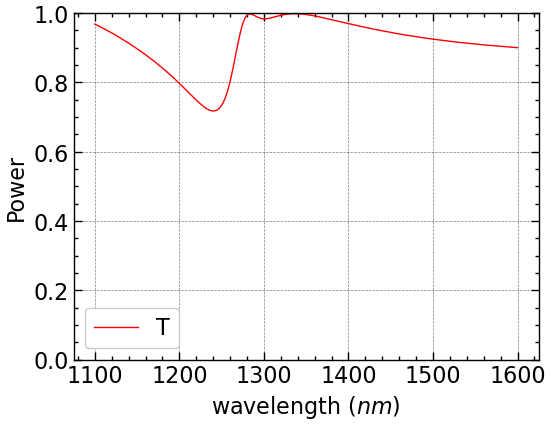

In [212]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, power / norm_power, "r", lw=1, label="T")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Power")
plt.ylim(0, 1)
plt.legend()
plt.savefig("power", dpi=300)
plt.show()

In [64]:
amps = np.array(dD.amps[0][0][:,0])
print(amps.shape)

(301,)


In [ ]:
import pandas as pd
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
print(pd.DataFrame(amps[0][0]).head())

                                                0                   1
0 -7.477880e-09-8.372133e-                    10j  0.400083+0.860127j
1 -7.466276e-09-2.064935e-                    09j  0.385044+0.867238j
2 -7.082986e-09-3.138136e-                    09j  0.369848+0.874091j
3 -6.485964e-09-3.902346e-                    09j  0.354497+0.880677j
4 -5.897012e-09-4.333861e-                    09j  0.339016+0.886985j


## Phase

In [74]:
phase = np.unwrap(np.angle(amps))

In [163]:
new_amps = batch_data["actual"]["diffraction_monitor"].amps

In [197]:
monitor = td.DiffractionMonitor(
    center=(0, 0, -Lz/2 + spc - (td.C_0 / fr.freq0)),
    size=(td.inf,td.inf,0),
    freqs=fr.freqs(N),
    name='diffraction_monitor',
    normal_dir='-', # away from structure
)

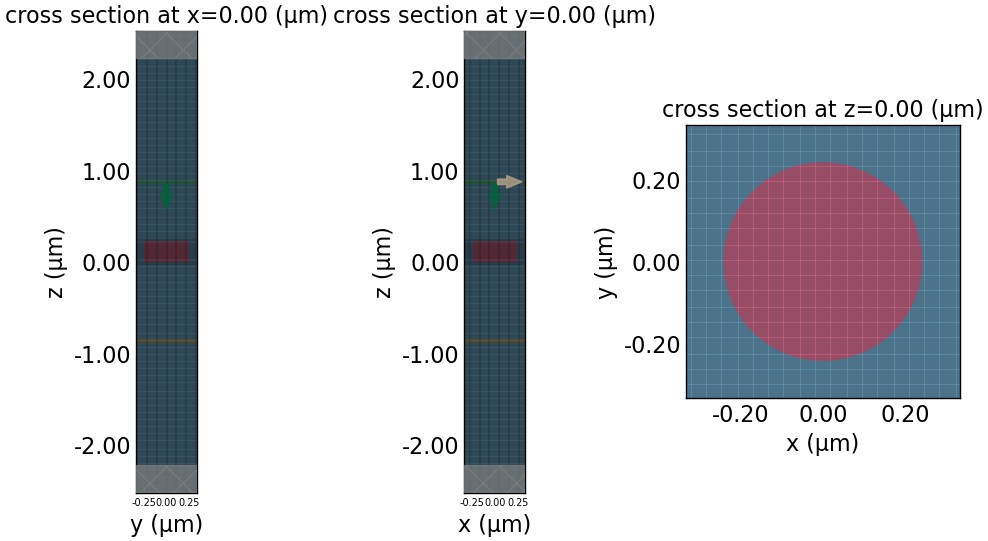

In [205]:
sims = simulation_helper(
    background=[polymer],
    monitors=[monitor],
    run_time=700 / (fr.fmax - fr.fmin)
)

In [206]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/huygens_pol")

Output()

22:17:43 EDT Started working on Batch containing 2 tasks.

22:17:45 EDT Maximum FlexCredit cost: 1.437 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

22:18:45 EDT Batch complete.

Output()

In [207]:
first_order = batch_data["actual"]["diffraction_monitor"].amps[1][1]
norm_amps = batch_data["norm"]["diffraction_monitor"].amps[1][1]
phase_p2 = np.unwrap(np.angle(first_order[:, 1]))
phase_p2 = phase_p2 - phase_p2[0]
norm_phase_p2 = np.unwrap(np.angle(norm_amps[:, 1]))
norm_phase_p2 = norm_phase_p2 - norm_phase_p2[0]

phase = phase_p2 - norm_phase_p2

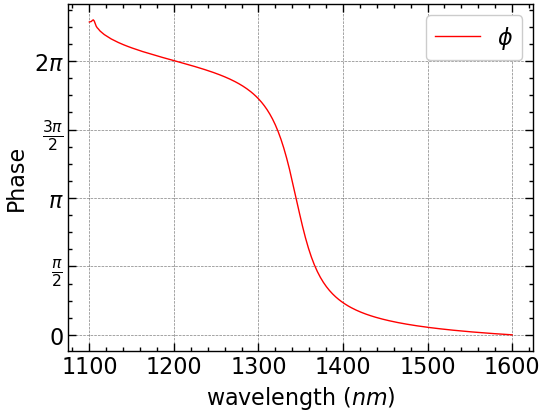

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase, "r", lw=1, label="$\phi$")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Phase")
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
ytick_labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", 
                r"$\frac{3\pi}{2}$", r"$2\pi$"]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.legend()
plt.legend()
plt.savefig("phase.png", dpi=300)
plt.show()